<a href="https://colab.research.google.com/github/priyanshu3489/Deepfake-detection-/blob/deepfake-generation/Deepfake_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# first part to generate

In [ ]:
import cv2
import numpy as np

def resize_frame(frame, target_height, target_width):
    """
    Resize a single frame to the target height and width.
    """
    return cv2.resize(frame, (target_width, target_height), interpolation=cv2.INTER_AREA)

def adjust_frames(video_frames, target_frames):
    """
    Adjust the number of frames to match the target number of frames.
    If the video has fewer frames, pad with black frames.
    If the video has more frames, trim the excess.
    """
    current_frames = len(video_frames)
    if current_frames < target_frames:
        # Pad with black frames
        padding = np.zeros((target_frames - current_frames, *video_frames[0].shape), dtype=np.uint8)
        video_frames = np.vstack((video_frames, padding))
    elif current_frames > target_frames:
        # Trim excess frames
        video_frames = video_frames[:target_frames]
    return video_frames

def preprocess_video(video_path, target_shape, output_path):
    """
    Preprocess a video to match the target shape [frames, 1, height, width, channels]
    and save the processed video.
    """
    target_frames, _, target_height, target_width, target_channels = target_shape

    # Read the video
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame
        frame = resize_frame(frame, target_height, target_width)
        frames.append(frame)

    cap.release()

    # Convert frames to a numpy array
    frames = np.array(frames)

    # Adjust the number of frames
    frames = adjust_frames(frames, target_frames)

    # Add the extra dimension for the target shape [133, 1, 93, 132, 3]
    frames = np.expand_dims(frames, axis=1)

    # Ensure the video has 3 channels
    if frames.shape[-1] != target_channels:
        raise ValueError(f"Video must have {target_channels} channels.")

    # Save the processed video
    save_video(frames, output_path)

    return frames

def save_video(frames, output_path):
    """
    Save the processed video to the specified output path.
    """
    # Remove the extra dimension [133, 1, 93, 132, 3] -> [133, 93, 132, 3]
    frames = np.squeeze(frames, axis=1)

    # Get video properties
    num_frames, height, width, _ = frames.shape
    fps = 30  # Frames per second (adjust as needed)

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write frames to the video file
    for frame in frames:
        out.write(frame)

    out.release()
    print(f"Processed video saved to {output_path}")

# Example usage
video_path = "/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00005.mp4"  # Path to your input video
output_path = "/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00005.mp4"  # Path to save the processed video
target_shape = (133, 1, 93, 132, 3)  # Target shape [frames, 1, height, width, channels]

# Preprocess the video and save it
processed_video = preprocess_video(video_path, target_shape, output_path)

# Check the shape of the processed video
print("Processed video shape:", processed_video.shape)

Processed video saved to /content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00005.mp4
Processed video shape: (133, 1, 93, 132, 3)


In [ ]:
pip install dlib opencv-python tensorflow numpy

In [ ]:
import cv2
import dlib

# Load the pre-trained face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/shape_predictor_68_face_landmarks.dat")

def detect_faces(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    return faces

def align_face(frame, face):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    shape = predictor(gray, face)
    return shape

In [ ]:
def extract_facial_region(frame, shape, target_size=(128, 128)):
    # Extract the facial region using the landmarks
    x, y = shape.part(0).x, shape.part(0).y
    w, h = shape.part(16).x - x, shape.part(8).y - y
    facial_region = frame[y:y+h, x:x+w]
    # Resize to a consistent size
    facial_region = cv2.resize(facial_region, target_size)
    return facial_region

In [ ]:
import numpy as np

def prepare_dataset(video_path, target_size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faces = detect_faces(frame)
        if len(faces) > 0:
            shape = align_face(frame, faces[0])
            facial_region = extract_facial_region(frame, shape, target_size)
            # Normalize pixel values to [0, 1]
            facial_region = facial_region / 255.0
            frames.append(facial_region)
    cap.release()
    # Stack frames along the sequence dimension
    return np.array(frames)

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, TimeDistributed, Conv2D, Flatten, Reshape, Input

def build_gru_model(input_shape):
    model = Sequential()
    # Input layer with the correct shape
    model.add(Input(shape=input_shape))
    # TimeDistributed Conv2D for processing each frame
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(Flatten()))
    # GRU layer for temporal modeling
    model.add(GRU(128, return_sequences=True))
    # Dense layer to predict the output frame
    model.add(TimeDistributed(Dense(input_shape[1] * input_shape[2] * input_shape[3], activation='sigmoid')))
    # Reshape to match the original frame shape
    model.add(TimeDistributed(Reshape(input_shape[1:])))
    return model

In [ ]:
def train_model(model, X_train, y_train):
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
def generate_deepfake_video(model, input_video_path, output_video_path, target_size=(128, 128)):
    cap = cv2.VideoCapture(input_video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faces = detect_faces(frame)
        if len(faces) > 0:
            shape = align_face(frame, faces[0])
            facial_region = extract_facial_region(frame, shape, target_size)
            # Normalize and predict
            facial_region_normalized = facial_region / 255.0
            # Reshape input to match model's expected shape
            facial_region_normalized = np.expand_dims(facial_region_normalized, axis=0)  # Add batch dimension
            facial_region_normalized = np.expand_dims(facial_region_normalized, axis=1)  # Add sequence dimension
            predicted_face_normalized = model.predict(facial_region_normalized)
            # Remove sequence and batch dimensions
            predicted_face_normalized = predicted_face_normalized[0, 0]
            # Denormalize and resize back to original size
            predicted_face = (predicted_face_normalized * 255).astype(np.uint8)
            predicted_face = cv2.resize(predicted_face, (shape.part(16).x - shape.part(0).x, shape.part(8).y - shape.part(0).y))
            # Replace the facial region in the frame with the predicted face
            x, y = shape.part(0).x, shape.part(0).y
            frame[y:y+predicted_face.shape[0], x:x+predicted_face.shape[1]] = predicted_face
        out.write(frame)

    cap.release()
    out.release()

In [ ]:
# Prepare datasets
video1_frames = prepare_dataset("/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00005.mp4")
video2_frames = prepare_dataset("/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00086.mp4")

# Ensure both datasets have the same length
min_length = min(len(video1_frames), len(video2_frames))
video1_frames = video1_frames[:min_length]
video2_frames = video2_frames[:min_length]

# Add a sequence dimension (assuming each frame is a sequence of length 1)
video1_frames = np.expand_dims(video1_frames, axis=1)
video2_frames = np.expand_dims(video2_frames, axis=1)

# Build and train the model
model = build_gru_model(video1_frames.shape[1:])
train_model(model, video1_frames, video2_frames)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - loss: 0.0442
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - loss: 0.0336
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.0210
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - loss: 0.0149
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - loss: 0.0137
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - loss: 0.0137
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.0130
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - loss: 0.0128
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - loss: 0.0123
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - loss: 0.0123


In [ ]:
!pip install tensorflow==2.17.1 tf-models-official==2.17.0

In [ ]:
# Save the video in a specific directory
output_path = "/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/deepfake_output.mp4"
generate_deepfake_video(model, "/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/00086.mp4", output_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

# **New**

In [ ]:
from google.colab import files

# Upload video file
uploaded = files.upload()

# Get the uploaded file name
video_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {video_filename}")

Saving cropped_faces.mp4 to cropped_faces.mp4
Uploaded file: cropped_faces.mp4


# **facial part cropped**

In [ ]:
import cv2
import os

# Load the video
cap = cv2.VideoCapture(video_filename)

# Get the uploaded file name
video_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {video_filename}")

# Load the video
cap = cv2.VideoCapture(video_filename)

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video
output_filename = 'cropped_faces.mp4'
out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (100, 100))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (100, 100))  # Resize face to fixed size
        out.write(face_resized)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Cropped face video saved as {output_filename}")

Uploaded file: 00005.mp4
Cropped face video saved as cropped_faces.mp4


# **Background remove**

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 65.4 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import numpy as np
from google.colab import files
import mediapipe as mp
import dlib

# Load the video
cap = cv2.VideoCapture(video_filename)

# Initialize face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/shape_predictor_68_face_landmarks.dat")

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video
output_filename = 'face_movement_changed.mp4'
out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Example: Shift all facial landmarks slightly to the right
        for i in range(68):
            x, y = landmarks.part(i).x + 10, landmarks.part(i).y
            cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Face movement changed video saved as {output_filename}")

Face movement changed video saved as face_movement_changed.mp4


In [ ]:
# Upload target video and face video
print("Upload the target video:")
target_video_file = files.upload()
target_video_filename = list(target_video_file.keys())[0]

print("Upload the cropped face video:")
face_video_file = files.upload()
face_video_filename = list(face_video_file.keys())[0]

Upload the target video:


Saving 00086.mp4 to 00086 (1).mp4
Upload the cropped face video:


Saving cropped_faces.mp4 to cropped_faces (2).mp4


In [ ]:
import cv2
import numpy as np
from google.colab import files



# Load the target video
cap_target = cv2.VideoCapture(target_video_filename)
cap_face = cv2.VideoCapture(face_video_filename)

# Get video properties
frame_width = int(cap_target.get(3))
frame_height = int(cap_target.get(4))
fps = int(cap_target.get(cv2.CAP_PROP_FPS))

# Define output video
output_filename = 'face_attached_video.mp4'
out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap_target.isOpened() and cap_face.isOpened():
    ret_target, frame_target = cap_target.read()
    ret_face, frame_face = cap_face.read()

    if not ret_target or not ret_face:
        break

    # Resize face frame to fit a specific position on the target video
    face_resized = cv2.resize(frame_face, (100, 100))  # Adjust size as needed
    x_offset, y_offset = 50, 50  # Adjusted position to avoid overlap issues

    # Calculate the target area's dimensions
    target_height, target_width = face_resized.shape[:2]

    # Ensure the target area is within the bounds of the target frame
    x_end = min(x_offset + target_width, frame_target.shape[1])
    y_end = min(y_offset + target_height, frame_target.shape[0])

    # Overlay the face video onto the target video
    frame_target[y_offset:y_end, x_offset:x_end] = face_resized[:y_end - y_offset, :x_end - x_offset]

    out.write(frame_target)

cap_target.release()
cap_face.release()
out.release()
cv2.destroyAllWindows()

print(f"Face attached video saved as {output_filename}")


Face attached video saved as face_attached_video.mp4


Saving cropped_faces.mp4 to cropped_faces (3).mp4
Uploaded file: cropped_faces (3).mp4


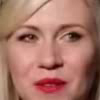

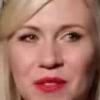

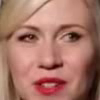

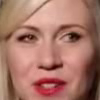

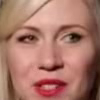

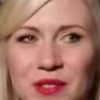

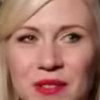

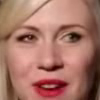

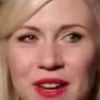

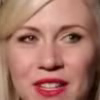

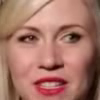

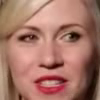

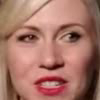

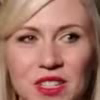

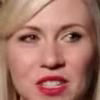

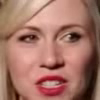

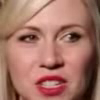

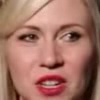

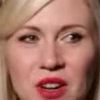

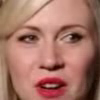

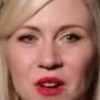

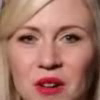

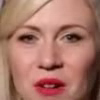

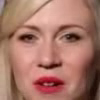

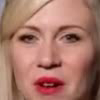

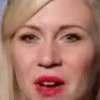

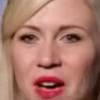

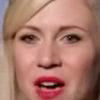

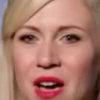

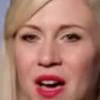

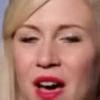

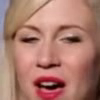

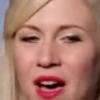

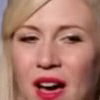

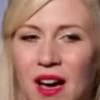

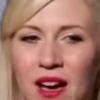

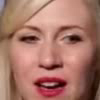

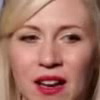

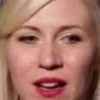

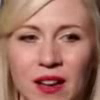

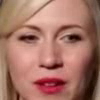

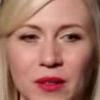

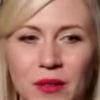

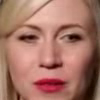

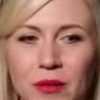

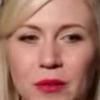

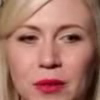

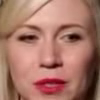

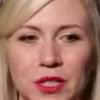

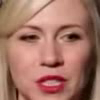

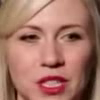

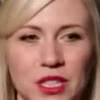

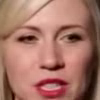

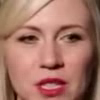

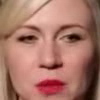

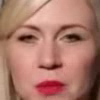

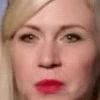

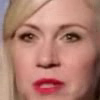

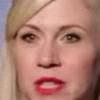

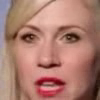

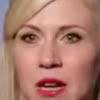

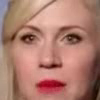

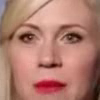

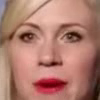

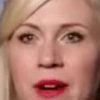

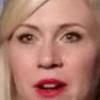

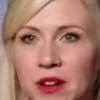

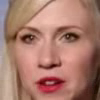

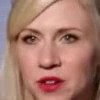

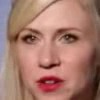

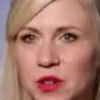

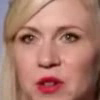

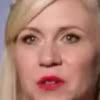

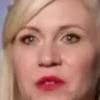

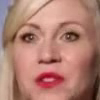

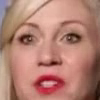

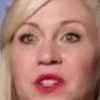

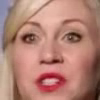

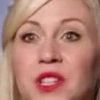

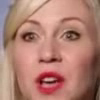

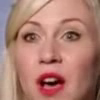

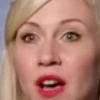

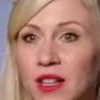

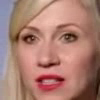

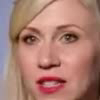

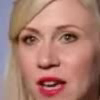

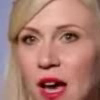

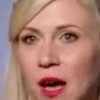

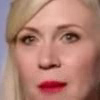

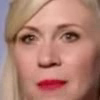

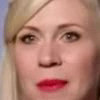

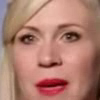

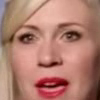

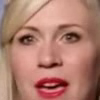

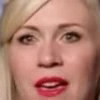

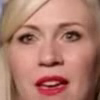

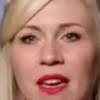

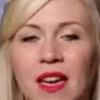

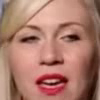

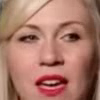

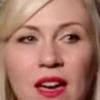

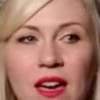

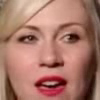

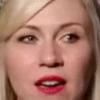

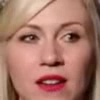

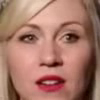

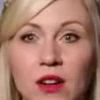

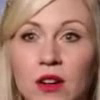

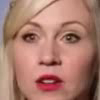

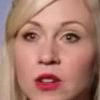

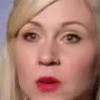

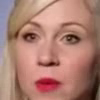

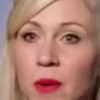

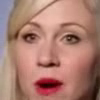

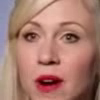

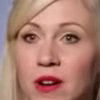

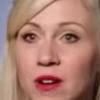

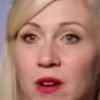

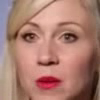

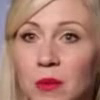

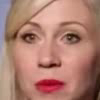

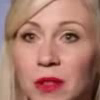

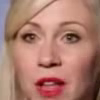

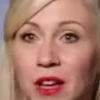

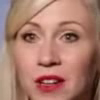

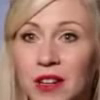

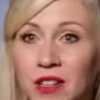

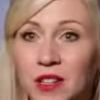

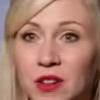

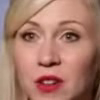

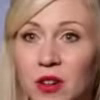

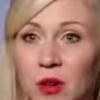

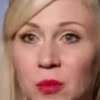

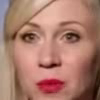

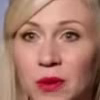

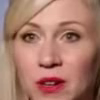

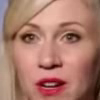

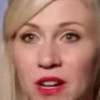

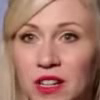

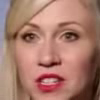

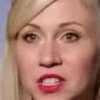

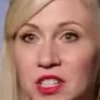

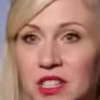

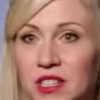

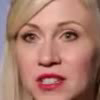

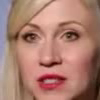

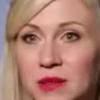

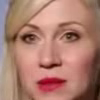

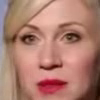

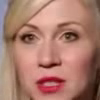

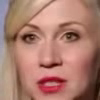

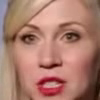

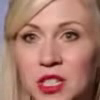

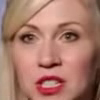

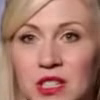

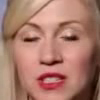

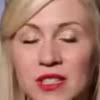

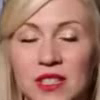

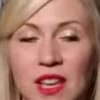

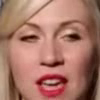

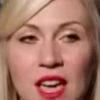

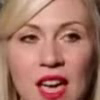

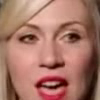

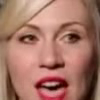

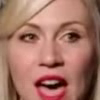

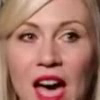

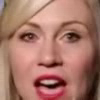

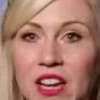

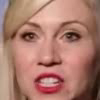

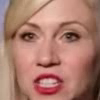

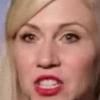

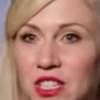

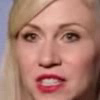

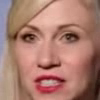

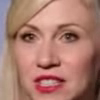

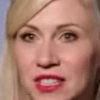

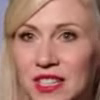

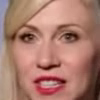

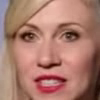

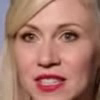

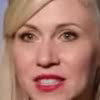

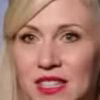

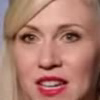

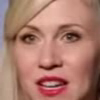

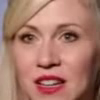

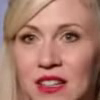

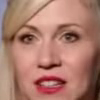

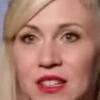

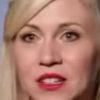

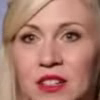

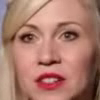

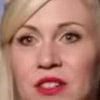

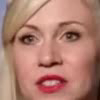

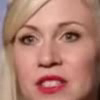

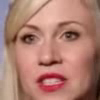

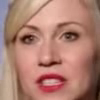

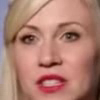

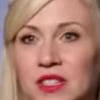

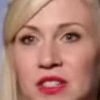

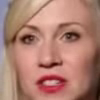

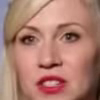

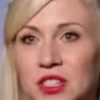

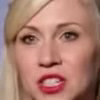

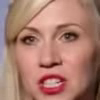

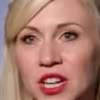

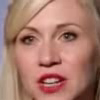

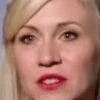

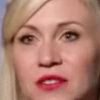

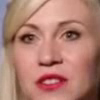

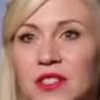

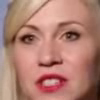

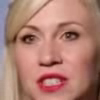

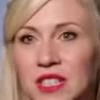

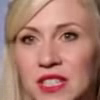

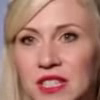

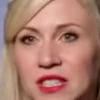

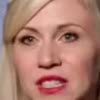

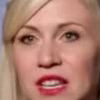

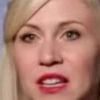

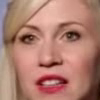

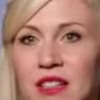

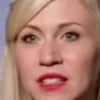

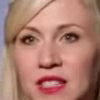

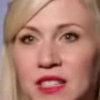

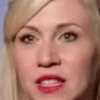

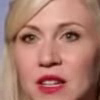

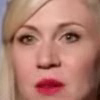

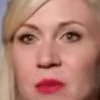

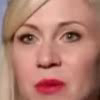

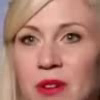

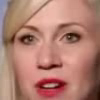

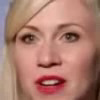

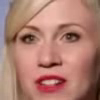

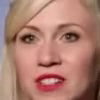

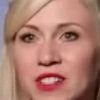

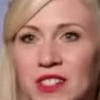

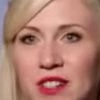

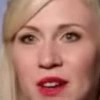

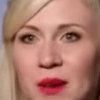

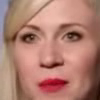

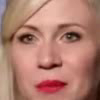

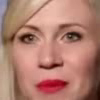

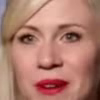

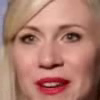

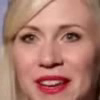

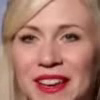

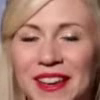

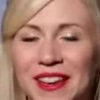

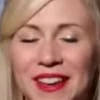

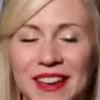

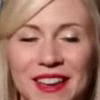

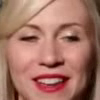

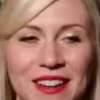

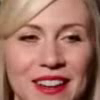

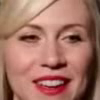

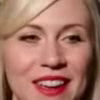

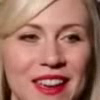

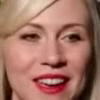

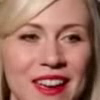

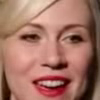

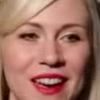

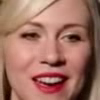

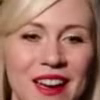

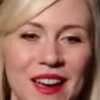

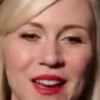

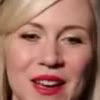

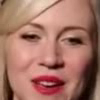

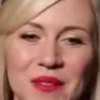

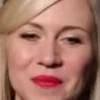

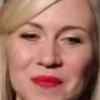

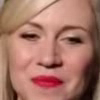

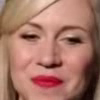

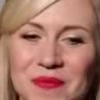

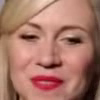

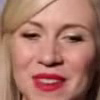

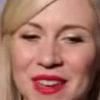

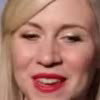

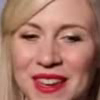

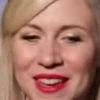

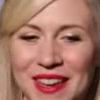

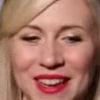

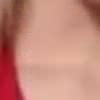

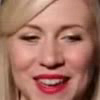

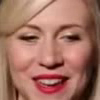

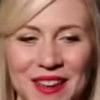

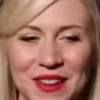

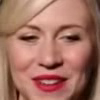

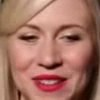

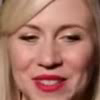

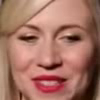

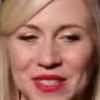

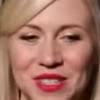

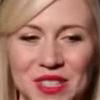

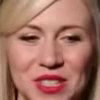

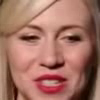

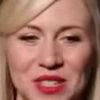

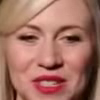

Video playback finished.


In [ ]:
import cv2
import numpy as np
from google.colab import files
# Import cv2_imshow from google.colab.patches
from google.colab.patches import cv2_imshow

# Upload video file
uploaded = files.upload()

# Get the uploaded file name
video_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {video_filename}")

# Load the video
cap = cv2.VideoCapture(video_filename)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Display the video frame using cv2_imshow instead of cv2.imshow
        cv2_imshow(frame)

        # Press 'q' to exit the video display
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

print("Video playback finished.")

# **train model**

In [ ]:
!pip install dlib opencv-python numpy tensorflow keras


In [ ]:
import cv2
import dlib
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load dlib's pre-trained model for face landmarks
predictor_path = "/content/drive/MyDrive/Colab Notebooks/Deepfake video generation/shape_predictor_68_face_landmarks.dat"

if not os.path.exists(predictor_path):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Load dataset and extract facial parts
data = []
labels = []

def extract_facial_parts(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        parts = []

        # Extract eyes, nose, and mouth as individual crops
        for i in range(36, 48):  # Eyes
            parts.append((landmarks.part(i).x, landmarks.part(i).y))

        for i in range(27, 36):  # Nose
            parts.append((landmarks.part(i).x, landmarks.part(i).y))

        for i in range(48, 68):  # Mouth
            parts.append((landmarks.part(i).x, landmarks.part(i).y))

        return parts
    return None

# Load images from dataset folder
dataset_folder = "dataset_faces/"
for filename in os.listdir(dataset_folder):
    image = cv2.imread(os.path.join(dataset_folder, filename))
    parts = extract_facial_parts(image)
    if parts:
        data.append(parts)
        labels.append(filename)

data = np.array(data)
labels = np.array(labels)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_faces/'